## Урок 5. Face Detection and Emotion Recognition

Нужно написать приложение, которое будет считывать и выводить кадры с веб-камеры. В процессе считывания определять что перед камерой находится человек, за детектировав его лицо на кадре. После этого, человек показывает жесты руками, а алгоритм должен считать их и определенным образом реагировать на эти жесты. 
На то, как система будет реагировать на определенные жесты - выбор за вами. Например, на определенный жест (жест пис), система будет здороваться с человеком. На другой, будет делать скриншот экрана. И т.д.
Для распознавания жестов, вам надо будет скачать датасет  https://www.kaggle.com/gti-upm/leapgestrecog, разработать модель для обучения и обучить эту модель.


In [1]:
# !mkdir -p ~/.kaggle
# !cp /content/kaggle.json ~/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json
# !kaggle datasets download -d  gti-upm/leapgestrecog

In [2]:
# !unzip -q /content/leapgestrecog.zip -d /content/data

In [3]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable
import cv2
from sklearn.model_selection import train_test_split

## Часть 1. Подготовка данных

In [4]:
train_dir = './data/leapGestRecog'
print(os.listdir(train_dir))

['09', '08', '03', '07', '02', '01', '05', '04', '00', '06']


In [5]:
train_dir

'./data/leapGestRecog'

In [6]:
test_dir = './data/leapgestrecog/leapGestRecog'
print(os.listdir(test_dir))

['09', '08', '03', '07', '02', '01', '05', '04', '00', '06']


In [7]:
folder_00 = os.listdir(train_dir + "/00")
print(f'Train Classes - {folder_00}')

Train Classes - ['05_thumb', '02_l', '10_down', '06_index', '07_ok', '04_fist_moved', '09_c', '01_palm', '08_palm_moved', '03_fist']


In [8]:
digit_to_classname = {0:'palm', 1:'fist', 2:'thumb', 3:'fist_moved', 4:'ok', 5:'palm_moved', 6:'c', 
                      7:'index', 8:'l', 9:'down'}

In [54]:
batch_size = 10

In [74]:
train_transforms = tt.Compose([tt.Grayscale(num_output_channels=1), # Картинки чернобелые
                         
                         # Настройки для расширения датасета
                         tt.RandomHorizontalFlip(),           # Случайные повороты на 90 градусов
                         tt.RandomRotation(30),               # Случайные повороты на 30 градусов
                         tt.RandomResizedCrop(640, scale=(1.0, 1.0)),
                         tt.Resize(48),
                         tt.ToTensor()])                      # Приведение к тензору

test_transforms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.ToTensor()])

In [112]:
train_dataset = ImageFolder(train_dir, train_transforms)
test_dataset  = ImageFolder(test_dir, test_transforms)

In [113]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 20000
    Root location: ./data/leapGestRecog
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], resample=False, expand=False)
               RandomResizedCrop(size=(640, 640), scale=(1.0, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               Resize(size=48, interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

In [114]:
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True,)
test_dataloader = DataLoader(test_dataset, batch_size, num_workers=3, pin_memory=True)

In [78]:
train_dataloader

In [115]:
test_dataloader

Создадим функцию для просмотра случайных картинок из получившегося датасета:

In [79]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape, len(images))
        ax.imshow(make_grid(images[:100], nrow=10).permute(1, 2, 0))
        break

torch.Size([1, 48, 48]) 10


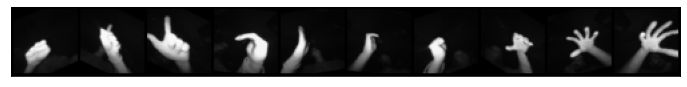

In [117]:
show_batch(train_dataloader)

torch.Size([1, 240, 640]) 10


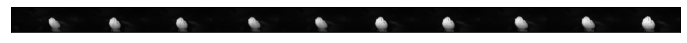

In [118]:
show_batch(test_dataloader)

In [81]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [82]:
device = get_default_device()
device

device(type='cuda')

In [83]:
train_dataloader = DeviceDataLoader(train_dataloader, device)
test_dataloader = DeviceDataLoader(test_dataloader, device)

## Часть 2. Создание модели

Опишем нашу модель для распознавания эмоций:

In [84]:
class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = self.conv_block(in_channels, 128)
        self.conv2 = self.conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(self.conv_block(128, 128), self.conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = self.conv_block(128, 256)
        self.conv4 = self.conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(self.conv_block(256, 256), self.conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = self.conv_block(256, 512)
        self.conv6 = self.conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(self.conv_block(512, 512), self.conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
    
    @staticmethod
    def conv_block(in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ELU(inplace=True)]
        if pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [85]:
model = to_device(ResNet(1, 10), device)

In [86]:
# model

## Часть 3. Обучение

In [87]:
# Если работаете на гпу, очищаем весь кэш
if torch.cuda.is_available(): 
    torch.cuda.empty_cache()


epochs = 50
max_lr = 0.008
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)

In [88]:
total_steps = len(train_dataloader)
print(f'{epochs} epochs, {total_steps} total_steps per epoch')

50 epochs, 2000 total_steps per epoch


Добавим learning_rate_sheduler:

In [89]:
print(torch.__version__)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_dataloader))

1.7.0+cu101


In [90]:
!nvidia-smi

Wed Dec  2 12:25:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    40W / 300W |  16095MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [91]:
epoch_losses = []

for epoch in range(epochs):
    
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_dataloader):
        # print(len(data))
        # print(len(labels))
        data, labels = Variable(data), Variable(labels)
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(data)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 10000 == 9999:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/10000}')
            time2 = time.time()
            print(f'Spend time for 10000 images: {time2 - time1} sec')
            time1 = time.time()
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)
    

Epoch 1, loss:  0.85296475921385
Epoch 2, loss:  0.3451566609373549
Epoch 3, loss:  0.3762199700778292
Epoch 4, loss:  0.42000630170176123
Epoch 5, loss:  0.49906618921600604
Epoch 6, loss:  0.48375417165883844
Epoch 7, loss:  0.3451052733456454
Epoch 8, loss:  0.25005211782254627
Epoch 9, loss:  0.2400171486342151
Epoch 10, loss:  0.20879092626049534
Epoch 11, loss:  0.2021986789219227
Epoch 12, loss:  0.20634123420826656
Epoch 13, loss:  0.2131252425314251
Epoch 14, loss:  0.20054680233688668
Epoch 15, loss:  0.21408296400862672
Epoch 16, loss:  0.18827172371203868
Epoch 17, loss:  0.1944852383039324
Epoch 18, loss:  0.17897024699703615
Epoch 19, loss:  0.1725461108541458
Epoch 20, loss:  0.17052453262635936
Epoch 21, loss:  0.15049061808865555
Epoch 22, loss:  0.1697508614939261
Epoch 23, loss:  0.1569546522941164
Epoch 24, loss:  0.13069020327855468
Epoch 25, loss:  0.14069762978879408
Epoch 26, loss:  0.12796779053151705
Epoch 27, loss:  0.11828512633344736
Epoch 28, loss:  0.1059

Посмотрим на нашу ошибку в процессе обучения:

Text(0.5, 1.0, 'losses vs. No. of epochs')

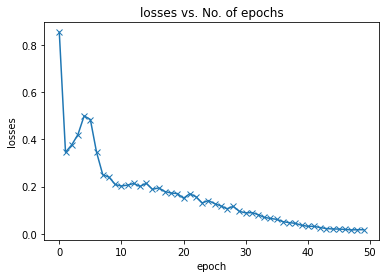

In [92]:
losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('losses vs. No. of epochs')

Сохраним нашу модель:

In [97]:
torch.save(model.state_dict(), './emotion_detection_model_state_50_epoch.pth')

## Часть 4. Результаты

Теперь давайте загрузим ее и будем использовать:

In [ ]:
net=ResNet(1, 10).to(device)
net.load_state_dict(torch.load('./emotion_detection_model_state_50_epoch.pth'))
net.eval()

Прогоним нашу нейронную сеть через тестовый датасет:

In [119]:
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        images, labels = data
        images, labels = Variable(images,volatile=True), Variable(labels,volatile=True)
        outputs = net(images)
        plt.title(f'gaused - {digit_to_classname(outputs[0].argmax())}, groud truth - {digit_to_classname(labels[0])}')
        plt.imshow(images[0].cpu().squeeze(), cmap='gray')
        plt.show()
        if i>10:
            break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.


RuntimeError: ignored

Напишем скрипт, в котором мы построим пайплайн распознавания эмоций найденного лица с изображения. Здесь со своей вебкамеры я ловлю кадры. На каждом кадре я нахожу лица и для каждого лица определяю эмоцию. И все это рисую прямо на кадре и отображаю через cv2.imshow:

In [ ]:
!pip install facenet_pytorch

In [109]:
import cv2
import torch
import numpy as np
from facenet_pytorch import MTCNN

# Создаем объект для считывания потока с веб-камеры(обычно вебкамера идет под номером 0. иногда 1)
cap = cv2.VideoCapture(0)  

# Класс детектирования и обработки лица с веб-камеры 
class FaceDetector(object):

    def __init__(self, mtcnn, resnet):
        self.mtcnn = mtcnn
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.emodel = resnet

    # Функция рисования найденных параметров на кадре
    def _draw(self, frame, boxes, probs, landmarks, emotion):
        try:
            for box, prob, ld in zip(boxes, probs, landmarks):
                # Рисуем обрамляющий прямоугольник лица на кадре
                cv2.rectangle(frame,
                              (box[0], box[1]),
                              (box[2], box[3]),
                              (0, 0, 255),
                              thickness=2)

                # пишем на кадре какая эмоция распознана
                cv2.putText(frame, 
                    emotion, (box[2], box[3]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

                # Рисуем особенные точки
                cv2.circle(frame, tuple(ld[0]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[1]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[2]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[3]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[4]), 5, (0, 0, 255), -1)
        except:
            print('Something wrong im draw function!')

        return frame
    
    # Функция для вырезания лиц с кадра
    @staticmethod
    def crop_faces(frame, boxes):
        faces = []
        for i, box in enumerate(boxes):
            faces.append(frame[int(box[1]):int(box[3]), 
                int(box[0]):int(box[2])])
        return faces
    
    @staticmethod
    def digit_to_classname(digit):
        if digit == 0:
            return 'sad'
        elif digit == 1:
            return 'disgust'
        elif digit == 2:
            return 'happy'
        elif digit == 3:
            return 'surprise'
        elif digit == 4:
            return 'neutral'
        elif digit == 5:
            return 'fear'
        elif digit == 6:
            return 'angry'
       
    # Функция в которой будет происходить процесс считывания и обработки каждого кадра
    def run(self):              
        # Заходим в бесконечный цикл
        while True:
            # Считываем каждый новый кадр - frame
            # ret - логическая переменая. Смысл - считали ли мы кадр с потока или нет
            ret, frame = cap.read()
            try:
                # детектируем расположение лица на кадре, вероятности на сколько это лицо
                # и особенные точки лица
                boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)
                
                # Вырезаем лицо из кадра
                face = self.crop_faces(frame, boxes)[0]
                # Меняем размер изображения лица для входа в нейронную сеть
                face = cv2.resize(face,(48,48))
                # Превращаем в 1-канальное серое изображение
                face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
                # Превращаем numpy-картинку вырезанного лица в pytorch-тензор
                torch_face = torch.from_numpy(face).unsqueeze(0).to(self.device).float()
                # Загужаем наш тензор лица в нейронную сеть и получаем предсказание
                emotion = self.emodel(torch_face[None, ...])
                # Интерпретируем предсказание как строку нашей эмоции
                emotion = self.digit_to_classname(emotion.argmax())

                # Рисуем на кадре
                self._draw(frame, boxes, probs, landmarks, emotion)

            except:
                print('Something wrong im main cycle!')

            # Показываем кадр в окне, и назвываем его(окно) - 'Face Detection'
            cv2.imshow('Face Detection', frame)
            
            # Функция, которая проверяет нажатие на клавишу 'q'
            # Если нажатие произошло - выход из цикла. Конец работы приложения
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
                
        # Очищаем все объекты opencv, что мы создали
        cap.release()
        cv2.destroyAllWindows()
        
        
# Загружаем мтцнн
mtcnn = MTCNN()

ourResNet = ResNet(1, 10).to(device)
ourResNet.load_state_dict(torch.load('./emotion_detection_model_state_50_epoch.pth'))
ourResNet.eval()
# Создаем объект нашего класса приложения
fcd = FaceDetector(mtcnn, ourResNet)
# Запускаем
fcd.run()

Something wrong im main cycle!


DisabledFunctionError: ignored